# Patchless MLP-Mixer

This is a preliminary exploration of an even simpler [MLP-Mixer](https://arxiv.org/abs/2105.01601) style architecture.

The architecture:
- Uses image rows and columns directly, instead of image patches.
- Uses a (novel?) classification method, heavily inspired by MLP-Mixer.
- Enables deep models, with low parameter counts.

It looks fairly promising (warrenting further investigation):
- Initial results (on MNIST and CIFAR-10) are good.
- The model is capable of overfitting MNIST and CIFAR-10, suggesting that it would do well with larger, more varied datasets.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers

In [2]:
class MixerMLP(layers.Layer):
    def __init__(self, outsize):
        super().__init__()
        self.layer_1 = layers.Dense(outsize, activation=tf.nn.gelu)
        self.layer_2 = layers.Dense(outsize)

    def call(self, inputs):
        h = self.layer_1(inputs)
        return self.layer_2(h)

class Mixer(layers.Layer):
    def __init__(self, outheight, outwidth):
        super().__init__()
        self.layer_1 = MixerMLP(outheight)
        self.layer_2 = MixerMLP(outwidth)

    def call(self, inputs):
        h = tf.keras.layers.Permute((2, 1))(inputs)
        h = self.layer_1(h)
        h = tf.keras.layers.Permute((2, 1))(h)
        return self.layer_2(h)

class ScalarGate(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.value = tf.Variable(0.0, trainable=True)

    def call(self, inputs):
        return self.value * inputs

def patchless_mixer(height, width, num_classes, num_mix_layers, name=None):
    inputs = tf.keras.layers.Input(shape=(height, width))
    
    h = inputs
    for i in range(num_mix_layers):
        h = ScalarGate()(Mixer(height, width)(h)) + h
    
    # Rather than average pooling, 
    # use MixerMLP for rows, and then cols, 
    # then concat.
    rows_out = MixerMLP(1)(h)
    rows_out = tf.keras.layers.Lambda(lambda x: x[:, :, 0])(rows_out)

    cols_out = tf.keras.layers.Permute((2, 1))(h)
    cols_out = MixerMLP(1)(cols_out)
    cols_out = tf.keras.layers.Lambda(lambda x: x[:, :, 0])(cols_out)

    concat = tf.keras.layers.Concatenate()([rows_out, cols_out])
    flat = tf.keras.layers.Flatten()(concat)
    y = tf.keras.layers.Dense(num_classes)(flat)
    return tf.keras.Model(inputs=inputs, outputs=y, name=name)


# MNIST

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, test_images = train_images.astype(np.float32), test_images.astype(np.float32)

height, width = train_images.shape[-2:]
num_classes = 10

In [4]:
num_mix_layers = 16
model = patchless_mixer(height, width, num_classes, num_mix_layers)
# print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
938/938 [==============================] - 40s 34ms/step - loss: 0.7748 - accuracy: 0.7369 - val_loss: 0.1471 - val_accuracy: 0.9571
Epoch 2/10
938/938 [==============================] - 30s 32ms/step - loss: 0.1262 - accuracy: 0.9612 - val_loss: 0.0952 - val_accuracy: 0.9698
Epoch 3/10
938/938 [==============================] - 30s 32ms/step - loss: 0.0784 - accuracy: 0.9758 - val_loss: 0.0753 - val_accuracy: 0.9777
Epoch 4/10
938/938 [==============================] - 30s 32ms/step - loss: 0.0606 - accuracy: 0.9816 - val_loss: 0.0757 - val_accuracy: 0.9782
Epoch 5/10
938/938 [==============================] - 30s 32ms/step - loss: 0.0473 - accuracy: 0.9853 - val_loss: 0.0707 - val_accuracy: 0.9789
Epoch 6/10
938/938 [==============================] - 30s 32ms/step - loss: 0.0365 - accuracy: 0.9886 - val_loss: 0.0609 - val_accuracy: 0.9813
Epoch 7/10
938/938 [==============================] - 30s 32ms/step - loss: 0.0274 - accuracy: 0.9911 - val_loss: 0.0721 - val_accuracy:

313/313 - 6s - loss: 0.0706 - accuracy: 0.9815


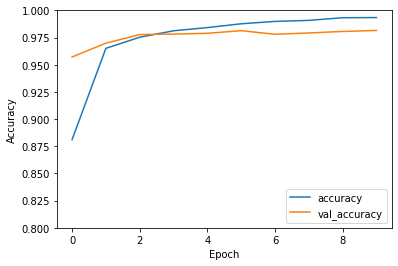

In [5]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.8, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

# CIFAR-10

In [8]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, test_images = train_images.astype(np.float32), test_images.astype(np.float32)
height, width, channels = 32, 32, 3
num_classes = 10

In [9]:
num_mix_layers = 32
inputs = tf.keras.layers.Input(shape=(height, width, channels))
reshaped = tf.keras.layers.Reshape([height, width * channels])(inputs)
model = patchless_mixer(height, width * channels, num_classes, num_mix_layers)(reshaped)
model = tf.keras.Model(inputs=inputs, outputs=model)
print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 96)            0         
_________________________________________________________________
model_1 (Functional)         (None, 10)                665008    
Total params: 665,008
Trainable params: 665,008
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 73s 74ms/step - loss: 1.8599 - accuracy: 0.3252 - val_loss: 1.3946 - val_accuracy: 0.5054
Epoch 2/10
782/782 [==============================] - 54s 69ms/step - loss: 1.3312 - accuracy: 0.5274 - val_loss: 1.2374 - val_accuracy: 0.5607
Epoch 3/10
782/782 [==============================] - 54s 70ms/step - loss: 1.1465 - accur

313/313 - 12s - loss: 1.9500 - accuracy: 0.6014


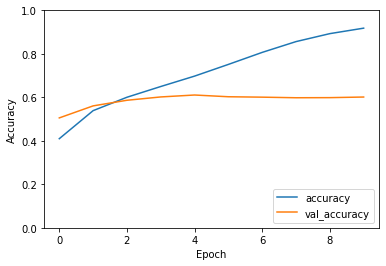

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)